In [ ]:
!pip install tensorflow.io
!pip install tensorflow-gpu
!pip install tensorflow-datasets

In [1]:
import json
import zipfile
import os
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.transform as sktrans
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Model, Sequential, metrics, optimizers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D,\
                                    MaxPooling2D, UpSampling2D, GlobalAveragePooling2D,\
                                    Layer, Lambda,Flatten, Reshape, Conv2DTranspose,\
                                    Activation, LeakyReLU, Dropout, InputLayer

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
batch_size = 64 

def crop_resize_normalize(item):
    img = item['image']
    # Normalise and resize image
    resized = tf.image.resize(tf.cast(img, tf.float32) / 255.0, [128, 128])
    item['image'] = resized
    return item

def preprocess(image):
    # Returns image, image because when training, vae expects same input image as output
    image = image['image']
    return image, image

def preprocess_test(image):
    return image['image']

# Download data
data, info = tfds.load("shapes3d", with_info=True, split='train[:5%]')
train_data, val_data, test_data = data, data, data

steps_per_epoch = info.splits['train'].num_examples // batch_size
validation_steps = info.splits['train'].num_examples // batch_size

# Define train, validation and test datasets
train_ds = train_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
val_ds = val_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
test_ds = test_data.map(crop_resize_normalize).map(preprocess_test).repeat().batch(batch_size).prefetch(1)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/480000 [00:00<?, ? examples/s]

Shuffling /home/ec2-user/tensorflow_datasets/shapes3d/2.0.0.incompleteNK1FIZ/shapes3d-train.tfrecord*...:   0%…

Dataset shapes3d downloaded and prepared to /home/ec2-user/tensorflow_datasets/shapes3d/2.0.0. Subsequent calls will reuse this data.


In [4]:
info.splits['train'].num_examples

480000

In [5]:
def encoder_network(input_shape, latent_dim=100):
    def sampling(args):
        z_mean, z_log_var = args
        epsilon_mean = 0
        epsilon_std = 1.0
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                  mean=epsilon_mean, stddev=epsilon_std)
        sampled_z = z_mean + K.exp(z_log_var / 2) * epsilon
        return sampled_z
    
    input_img = Input(shape=input_shape)
    x = Conv2D(32, 4, strides=(2, 2))(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 4, strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = GlobalAveragePooling2D()(x)

    z_mean = Dense(latent_dim, name='mean')(x)
    z_log_var = Dense(latent_dim)(x)
    z = Lambda(sampling)([z_mean, z_log_var])

    encoder = Model(input_img, z)
    return encoder, z_mean, z_log_var

def decoder_network(latent_dim=100):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(4096)(decoder_input)
    x = Reshape((4, 4, 256))(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(128, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(64, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(32, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2), interpolation='nearest')(x)
    x = Conv2D(3, 3, strides=1, padding='same', activation='sigmoid')(x)

    decoder = Model(decoder_input, x)
    return decoder

def kl_loss():
    kl = K.mean(-0.5 * K.sum(1 + z_log_var \
                      - K.square(z_mean) \
                      - K.exp(z_log_var), axis=-1))
    return kl

def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain VAE'''
    return K.mean(K.sum(K.binary_crossentropy(
        K.batch_flatten(x), 
        K.batch_flatten(t_decoded)), axis=-1))

def vae_loss(x, z_decoded):
    '''Total loss for the DFC VAE'''
    return 5e-1 * reconstruction_loss(x, z_decoded) + kl_loss()


### Train and test models

In [ ]:
latent_dim = 100 
epochs = 1 

input_shape = (128, 128, 3)

encoder, z_mean, z_log_var = encoder_network(input_shape, latent_dim)
z_encoded = encoder.output
decoder = decoder_network(latent_dim)
z_decoded = decoder(z_encoded)

vae = Model(encoder.input, z_decoded)

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

vae.compile(optimizer=opt, loss=vae_loss)

train_iterator = tf.compat.v1.data.make_one_shot_iterator(train_ds)
val_iterator = tf.compat.v1.data.make_one_shot_iterator(val_ds)

vae.fit(train_ds.shuffle(1000),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_ds,
        validation_steps=validation_steps)

In [ ]:
encoder.save_weights("encoder-shapes.h5")
decoder.save_weights("decoder-shapes.h5")

### Use trained model

#### Can model recall seen images?

In [6]:
latent_dim = 100 
input_shape = (128, 128, 3)

encoder, z_mean, z_log_var = encoder_network(input_shape, latent_dim)
decoder = decoder_network(latent_dim)

encoder.load_weights("encoder-shapes.h5")
decoder.load_weights("decoder-shapes.h5")

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Download data
data, info = tfds.load("shapes3d", with_info=True, split='train[:5%]')
train_data, val_data, test_data = data, data, data

steps_per_epoch = info.splits['train'].num_examples // batch_size
validation_steps = info.splits['train'].num_examples // batch_size

# Define train, validation and test datasets
train_ds = train_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
val_ds = val_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
test_ds = test_data.map(crop_resize_normalize).map(preprocess_test).repeat().batch(batch_size).prefetch(1)

In [8]:
n = 10
generator = tf.compat.v1.data.make_one_shot_iterator(test_ds)
x_test = generator.get_next()
x_test = tfds.as_numpy(x_test)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


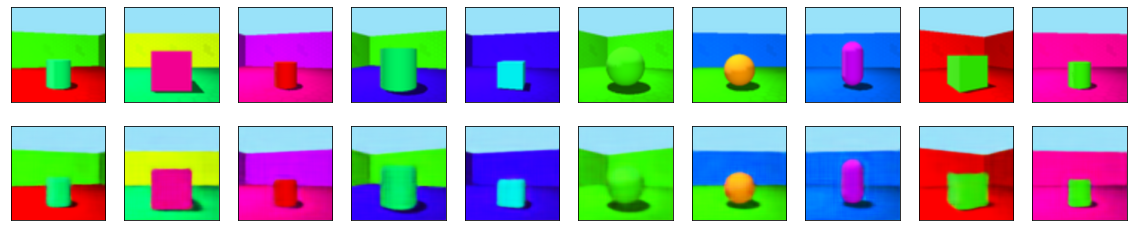

In [9]:
code = Model(encoder.input, encoder.get_layer('mean').output)
encoded_imgs = code.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### classification from latent variables

In [153]:
def preprocess(image):
    return image['image']

def get_shape(item):
    #return item['value_shape']
    #return item['label_object_hue']
    return item['label_scale']

# Download data
data, info = tfds.load("shapes3d", with_info=True, split='train[10%:15%]')
train_data, val_data, test_data = data, data, data

batch_size=2000

steps_per_epoch = info.splits['train'].num_examples // batch_size
validation_steps = info.splits['train'].num_examples // batch_size

# Define train, validation and test datasets
test_ds = train_data.map(crop_resize_normalize).map(preprocess).repeat().batch(batch_size).prefetch(1)
shapes = train_data.map(get_shape).batch(batch_size).prefetch(1)

In [154]:
n = 2000
generator = tf.compat.v1.data.make_one_shot_iterator(test_ds)
x_test = generator.get_next()
x_test = tfds.as_numpy(x_test)

In [155]:
n = 2000
generator = tf.compat.v1.data.make_one_shot_iterator(shapes)
shapes = generator.get_next()
shapes = tfds.as_numpy(shapes)

In [156]:
encoded_imgs = code.predict(x_test)

In [157]:
encoded_imgs[0].shape

(100,)

In [158]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron

X_train, X_test, y_train, y_test = train_test_split(encoded_imgs, shapes, 
                                                    test_size=0.5, random_state=1)
num_examples = [10,20,30,40,50,100,200,300,400,500]
scores = []

for num in num_examples:
    clf = Perceptron()
    #clf = MLPClassifier(hidden_layer_sizes=100)
    #clf = SVC(C=10)
    clf.fit(X_train[0:num], y_train[0:num])
    score = clf.score(X_test, y_test)
    scores.append(score)

In [159]:
scores

[0.206, 0.252, 0.26, 0.274, 0.299, 0.365, 0.427, 0.479, 0.454, 0.507]

Text(0.5, 1.0, 'Accuracy against training dataset size \n(object shape vector classifier)')

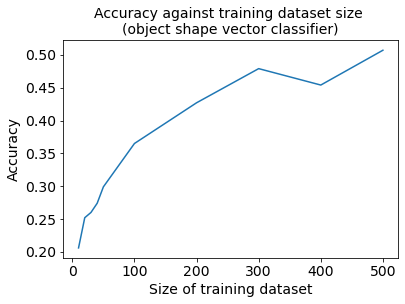

In [160]:
import matplotlib.pyplot as plt
plt.plot(num_examples, scores)
plt.xlabel('Size of training dataset', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Accuracy against training dataset size \n(object shape vector classifier)', fontsize=14)
#plt.savefig('MLP_shape.png', bbox_inches='tight')

### Convolutional network from scratch comparison

In [161]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(set(shapes))
input_shape = (128, 128, 3)

X_train, X_test, y_train, y_test = train_test_split(x_test, shapes, 
                                                    test_size=0.5, random_state=1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def train_from_scratch(num):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(len(set(shapes)), activation="softmax"),
        ]
    )

    batch_size = 128
    epochs = 10

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    model.fit(X_train[0:num], y_train[0:num], batch_size=batch_size, epochs=epochs, validation_split=0.05)

    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [162]:
y_train.shape

(1000, 8)

In [163]:
accs = []
nums = [10,20,30,40,50,100,200,300,400,500]

for num in nums:
    print(num)
    acc = train_from_scratch(num)
    print(acc)
    accs.append(acc)

10
Train on 9 samples, validate on 1 samples
Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 2.1715 - accuracy: 0.1111

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


9/9 [==============================] - 12s 1s/sample - loss: 2.1715 - accuracy: 0.1111 - val_loss: 3.3799 - val_accuracy: 0.0000e+00
Epoch 2/10
9/9 [==============================] - 0s 10ms/sample - loss: 1.4947 - accuracy: 0.3333 - val_loss: 3.7058 - val_accuracy: 0.0000e+00
Epoch 3/10
9/9 [==============================] - 0s 10ms/sample - loss: 1.3348 - accuracy: 0.5556 - val_loss: 3.1752 - val_accuracy: 0.0000e+00
Epoch 4/10
9/9 [==============================] - 0s 10ms/sample - loss: 0.8967 - accuracy: 0.6667 - val_loss: 2.7816 - val_accuracy: 0.0000e+00
Epoch 5/10
9/9 [==============================] - 0s 9ms/sample - loss: 0.6854 - accuracy: 0.7778 - val_loss: 2.6847 - val_accuracy: 0.0000e+00
Epoch 6/10
9/9 [==============================] - 0s 9ms/sample - loss: 0.5067 - accuracy: 0.8889 - val_loss: 3.0560 - val_accuracy: 0.0000e+00
Epoch 7/10
9/9 [==============================] - 0s 9ms/sample - loss: 0.3716 - accuracy: 0.8889 - val_loss: 3.7619 - val_accuracy: 0.0000e+00


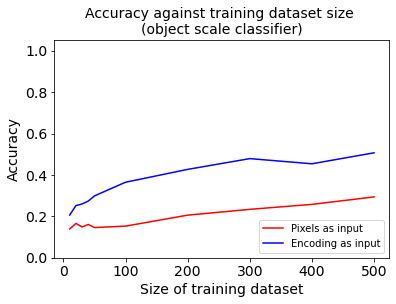

In [164]:
import matplotlib.pyplot as plt
plt.plot(nums, accs, label='Pixels as input', color='r')
plt.plot(num_examples, scores, label = 'Encoding as input', color='b')
plt.xlabel('Size of training dataset', fontsize=14)
plt.legend(loc='lower right')
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,1.05)
plt.title('Accuracy against training dataset size \n(object scale classifier)', fontsize=14)
plt.savefig('scale.png', bbox_inches='tight')